In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

from spatialdata import read_zarr

import sparrow as sp

the value of the environment variable BASIC_DCT_BACKEND is not in ["JAX","SCIPY"]


In [ ]:

sdata_16BT=read_zarr( "/Users/Xenium/20240522__175628__20240522_GC1_run2/output-XETG00238__0017216__Region_1__20240522__175701/sparrow/sdata_0017216__Region_1_final.zarr" )
sdata_16OT=read_zarr( "/Users/Xenium/20240312__162050__20240312_GC1/output-XETG00238__0014544__Region_2__20240312__162118/sparrow/sdata_0014544__Region_2_final.zarr" )
sdata_17OT=read_zarr( "/Users/Xenium/20240522__175628__20240522_GC1_run2/output-XETG00238__0017216__Region_3__20240522__175701/sparrow/sdata_0017216__Region_3_final.zarr" )
sdata_18OT=read_zarr( "/Users/Xenium/20240522__175628__20240522_GC1_run2/output-XETG00238__0017213__Region_2__20240522__175701/sparrow/sdata_0017213__Region_2_final.zarr" )
sdata_19BT=read_zarr( "/Users/Xenium/20240312__162050__20240312_GC1/output-XETG00238__0014600__Region_1__20240312__162118/sparrow/sdata_0014600__Region_1_final.zarr" )
sdata_19OT=read_zarr( "/Users/Xenium/20240312__162050__20240312_GC1/output-XETG00238__0014544__Region_1__20240312__162118/sparrow/sdata_0014544__Region_1_final.zarr" )
sdata_26OT=read_zarr( "/Users/Xenium/20240522__175628__20240522_GC1_run2/output-XETG00238__0017213__Region_1__20240522__175701/sparrow/sdata_0017213__Region_1_final.zarr" )
sdata_36OT=read_zarr( "/Users/Xenium/20240522__175628__20240522_GC1_run2/output-XETG00238__0017213__Region_3__20240522__175701/sparrow/sdata_0017213__Region_3_final.zarr" )


Given: two spatialdata objects containing image layers; segmentation masks (obtained through sp.im.segment); corresponding corresponding shapes layers and transcripts in the points layer.

In [ ]:
#sp.pl.plot_image( sdata_2, img_layer=[ "transcript_density", "clahe" ], crd=None )

In [ ]:
# _REGION_KEY is column in adata.obs, and is named 'fov_labels'
# UPDATE 7/06: this should be linked to a labels layer in the spatialdata object, in order to be able to use bounding_box_query of spatialdata
# therefore, we just copy the obtained segmentation mask with a different name

region_name_list = [ "GC16_BT_NR", "GC16_OT_NR", "GC17_OT_NR", "GC18_OT_NR", "GC19_BT_NR", "GC19_OT_NR", "GC26_OT_NR", "GC36_OT_NR" ]  # pick a name for each sample

sdata_list=[ sdata_16BT, sdata_16OT, sdata_17OT, sdata_18OT, sdata_19BT, sdata_19OT, sdata_26OT,  sdata_36OT ]

for _region, _sdata in zip( region_name_list, sdata_list ):

    _sdata = sp.im._add_label_layer( _sdata,
                                    arr = _sdata.labels[ "segmentation_mask" ].data,
                                    output_layer=_region, overwrite= True )

Allocate the transcripts

In [ ]:
for _region, _sdata in zip( region_name_list, sdata_list ):

    _sdata=sp.tb.allocate(
       _sdata,
        labels_layer=_region, # update 7/06 this way labels layers and adata will be linked
        shapes_layer="segmentation_mask_boundaries",
        points_layer="transcripts",
    )

In [6]:
import dask.array as da
import spatialdata
from spatialdata import SpatialData
from spatialdata.transformations import Translation

from sparrow.shape._shape import _filter_shapes_layer


def _crop_sdata( sdata, labels_layer:str, img_layer: str, min_coordinate: list[ int,int ], max_coordinate: list[ int,int ] , path = None ):

    # min_coordinates , y, x
    # max_coordinates y, x
    crop_mask=sdata.labels[ labels_layer ].data[ min_coordinate[ 0 ]: max_coordinate[0], min_coordinate[ 1 ]: max_coordinate[1] ]
    crop_mask=crop_mask.rechunk( crop_mask.chunksize )

    crop_image=sdata.images[ img_layer ].data[ :, min_coordinate[ 0 ]: max_coordinate[0], min_coordinate[ 1 ]: max_coordinate[1]  ]
    crop_image=crop_image.rechunk( crop_image.chunksize )

    cells_to_select=da.unique( crop_mask ).compute()

    sdata.table.obs[ "cell_ID" ]

    adata=sdata.table.copy()

    filtered_adata = adata[adata.obs['cell_ID'].isin(cells_to_select), :]

    sdata_crop = SpatialData()

    if path is not None:
        sdata_crop.write( path )

    sdata_crop.table = spatialdata.models.TableModel.parse(filtered_adata)

    translation = Translation([ min_coordinate[0] ,  min_coordinate[1] ], axes=("y", "x"))

    # add labels to the crop
    sdata_crop = sp.im._add_label_layer(
        sdata_crop,
        arr=crop_mask,
        output_layer = labels_layer, # you can choose any name
        transformation=translation,
        overwrite=False,
    )


    sdata_crop = sp.im._add_image_layer(
        sdata_crop,
        arr=crop_image,
        output_layer = img_layer, # you can choose any name
        transformation=translation,
        overwrite=True,
    )


    # optional if you would like to add a shapes layer
    sdata_crop = sp.sh._add_shapes_layer(
        sdata_crop,
        input = crop_mask,
        output_layer = f"{labels_layer}_boundaries",
        transformation=translation,
        overwrite=True
        )

    indexes_to_keep = sdata_crop.table.obs.index.values.astype(int)
    sdata_crop = _filter_shapes_layer(
        sdata_crop,
        indexes_to_keep=indexes_to_keep,
        prefix_filtered_shapes_layer="filtered_crop",
    )

    return sdata_crop

In [ ]:
path = "/Users/Xenium/All_samples_together"
# assume y,x for coordinates
min_coordinate=[ 11500, 7500 ]
max_coordinate = [ 19000, 18000 ]

labels_layer = "GC16_BT_NR"
sdata_16BT_crop=_crop_sdata(
    sdata_16BT,
    labels_layer=labels_layer,
    img_layer="clahe",
    min_coordinate=min_coordinate,
    max_coordinate=max_coordinate,
    path = os.path.join( path, f"sdata_crop_{labels_layer}.zarr" ),
      )

sp.pl.plot_shapes(sdata_16BT_crop, img_layer="clahe", shapes_layer=f"{labels_layer}_boundaries", figsize=(5,5))


min_coordinate=[ 7000, 3000 ]
max_coordinate = [ 13000, 12000 ]

labels_layer = "GC16_OT_NR"
sdata_16OT_crop=_crop_sdata(
    sdata_16OT,
    labels_layer=labels_layer,
    img_layer="clahe",
    min_coordinate=min_coordinate,
    max_coordinate=max_coordinate,
    path = os.path.join( path, f"sdata_crop_{labels_layer}.zarr" ),
      )

sp.pl.plot_shapes(sdata_16OT_crop, img_layer="clahe", shapes_layer=f"{labels_layer}_boundaries", figsize=(5,5))


min_coordinate=[ 9000, 18000 ]
max_coordinate = [ 20000, 37000 ]

labels_layer = "GC17_OT_NR"
sdata_17OT_crop=_crop_sdata(
    sdata_17OT,
    labels_layer=labels_layer,
    img_layer="clahe",
    min_coordinate=min_coordinate,
    max_coordinate=max_coordinate,
    path = os.path.join( path, f"sdata_crop_{labels_layer}.zarr" ),
      )

sp.pl.plot_shapes(sdata_17OT_crop, img_layer="clahe", shapes_layer=f"{labels_layer}_boundaries", figsize=(5,5))


min_coordinate=[ 17000, 30000 ]
max_coordinate = [ 25000, 39000 ]

labels_layer =  "GC18_OT_NR"
sdata_18OT_crop=_crop_sdata(
    sdata_18OT,
    labels_layer=labels_layer,
    img_layer="clahe",
    min_coordinate=min_coordinate,
    max_coordinate=max_coordinate,
    path = os.path.join( path, f"sdata_crop_{labels_layer}.zarr" ),
      )

sp.pl.plot_shapes(sdata_18OT_crop, img_layer="clahe", shapes_layer=f"{labels_layer}_boundaries", figsize=(5,5))


min_coordinate=[ 2500, 2300 ]
max_coordinate = [ 7000, 10000 ]

labels_layer = "GC19_BT_NR"
sdata_19BT_crop=_crop_sdata(
    sdata_19BT,
    labels_layer=labels_layer,
    img_layer="clahe",
    min_coordinate=min_coordinate,
    max_coordinate=max_coordinate,
    path = os.path.join( path, f"sdata_crop_{labels_layer}.zarr" ),
      )

sp.pl.plot_shapes(sdata_19BT_crop, img_layer="clahe", shapes_layer=f"{labels_layer}_boundaries", figsize=(5,5))


min_coordinate=[ 14000, 11000 ]
max_coordinate = [ 31000, 45000 ]

labels_layer = "GC26_OT_NR"
sdata_26OT_crop=_crop_sdata(
    sdata_26OT,
    labels_layer=labels_layer,
    img_layer="clahe",
    min_coordinate=min_coordinate,
    max_coordinate=max_coordinate,
    path = os.path.join( path, f"sdata_crop_{labels_layer}.zarr" ),
      )

sp.pl.plot_shapes(sdata_26OT_crop, img_layer="clahe", shapes_layer=f"{labels_layer}_boundaries", figsize=(5,5))


In [ ]:
# check if data is not normalized already

sdata_list=[ sdata_16BT_crop, sdata_16OT_crop, sdata_17OT_crop, sdata_18OT_crop, sdata_19BT_crop, sdata_19OT, sdata_26OT_crop, sdata_36OT  ]

for _sdata in sdata_list:
    print ( _sdata.table.to_df().head() )

sdata_list=[ sdata_16BT, sdata_16OT, sdata_17OT, sdata_18OT, sdata_19BT, sdata_19OT, sdata_26OT, sdata_36OT  ]

for _sdata in sdata_list:
    print ( _sdata.table.to_df().head() )


Set unique region key for each table in the spatialdata object (this could be responder_1, responder_2, non_responder_1,...). In this example we choose 'region_1' and 'region_2'.

In [ ]:
import anndata as ad
import pandas as pd
import spatialdata
from spatialdata import SpatialData

from sparrow.table._keys import _CELL_INDEX, _INSTANCE_KEY, _REGION_KEY

region_name_list = [ "GC16_BT_NR", "GC16_OT_NR", "GC17_OT_NR", "GC18_OT_NR", "GC19_BT_NR", "GC19_OT_NR", "GC26_OT_NR", "GC36_OT_NR" ]  # pick a name for each sample

sdata_list=[ sdata_16BT_crop, sdata_16OT_crop, sdata_17OT_crop, sdata_18OT_crop, sdata_19BT_crop, sdata_19OT, sdata_26OT_crop, sdata_36OT  ]

#sdata_list=[ sdata_16BT, sdata_16OT, sdata_17OT, sdata_18OT, sdata_19BT, sdata_19OT, sdata_26OT, sdata_36OT  ]


adata_list=[]

for _sdata in sdata_list:
    adata_list.append( _sdata.table.copy() )

assert len( region_name_list ) == len( adata_list )

#for adata, region in zip( adata_list,  region_name_list ):
#    adata.obs[ _REGION_KEY ] = pd.Categorical([region ] * len(adata.obs))

adata_merged= ad.concat(adata_list, axis=0)

# create new spatialdata object, and add the table

sdata_merged=SpatialData()

sdata_merged.table = spatialdata.models.TableModel.parse(
    adata_merged, region_key=_REGION_KEY, region=adata_merged.obs[ _REGION_KEY ].cat.categories.values, instance_key=_INSTANCE_KEY
)

# we assume segmentation mask are named "segmentation_mask" in all samples

for _sdata, region in zip(sdata_list , region_name_list ):
    sdata_merged=sp.im._add_label_layer( sdata_merged, _sdata[ region ].data, output_layer=region, overwrite=True )

sdata_merged.write( os.path.join( path, "sdata_merged.zarr" ) )

In [11]:
sdata_merged.table[ sdata_merged.table.obs[ "fov_labels" ] == "GC26_OT_NR" ].to_df()

gene,ACER1,ACTA2,ADAM12,AHNAK2,AIF1,AKR1C1,ALOX5AP,AP1S2,APCDD1,APOD,...,UBE2C,VCAN,VEGFA,VIM,VWF,WDFY4,XCL1,XCL2,XCR1,ZNF667-AS1
cells,,,,,,,,,,,,,,,,,,,,,
2915,0,0,1,0,0,1,0,5,0,1,...,1,5,13,4,0,0,0,0,0,1
3427,0,0,2,0,0,0,0,43,0,4,...,0,0,3,17,0,0,0,0,0,0
4451,0,0,0,0,0,0,1,16,0,6,...,0,0,0,17,0,0,0,0,0,0
5475,0,0,0,0,0,0,1,11,1,1,...,0,0,4,14,0,0,0,0,0,0
5987,0,0,0,0,0,0,1,19,0,3,...,0,0,1,11,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987966,0,0,0,0,1,1,3,1,0,0,...,0,0,0,3,0,0,0,0,0,0
988478,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
988990,0,0,0,0,0,0,0,2,0,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
import scanpy as sc
from sparrow.image._image import _get_spatial_element
from sparrow.table._preprocess import _get_mask_area


def preprocess( sdata, region_name_list:list[str], min_counts=10, min_cells=5, n_comps=50 ):
    """"Preprocess"""
    adata=sdata.table.copy()

    # Calculate QC Metrics

    sc.pp.calculate_qc_metrics(adata, inplace=True, percent_top=[2, 5])

    # Filter cells and genes
    sc.pp.filter_cells(adata, min_counts=min_counts)
    sc.pp.filter_genes(adata, min_cells=min_cells)

    # normalize by cell size
    # we do not want to loose the index (_CELL_INDEX)
    old_index = adata.obs.index
    for i, _labels_layer in enumerate(region_name_list ):
        se = _get_spatial_element(sdata, layer=_labels_layer)
        _shapesize = _get_mask_area(se.data)

        _shapesize.index.name = _INSTANCE_KEY

        _shapesize.name = "shapeSize"
        _shapesize = _shapesize.to_frame().reset_index()
        _shapesize[_REGION_KEY] = _labels_layer
        _shapesize[_INSTANCE_KEY]=_shapesize[ _INSTANCE_KEY].astype( int )
        if i == 0:
            shapesize = _shapesize
        else:
            shapesize = pd.concat([shapesize, _shapesize], ignore_index=True)
    # note that we checked that adata.obs[ _INSTANCE_KEY ] is unique for given region (see self._get_adata())
    adata.obs = pd.merge(adata.obs.reset_index(), shapesize, on=[_INSTANCE_KEY, _REGION_KEY], how="left")
    adata.obs.index = old_index
    adata.obs = adata.obs.drop(columns=[_CELL_INDEX])

    adata.obs[ _REGION_KEY ]=adata.obs[ _REGION_KEY ].astype( "category" )

    adata.layers["raw_counts"] = adata.X

    adata.X = (adata.X.T * 100 / adata.obs.shapeSize.values).T
    sc.pp.log1p(adata)
    # need to do .copy() here to set .raw value, because .scale still overwrites this .raw, which is unexpected behaviour
    adata.raw = adata.copy()
    sc.pp.scale(adata, max_value=10)

    sc.tl.pca(adata, svd_solver="arpack", n_comps=n_comps)

    if "spatialdata_attrs" in adata.uns.keys():
        adata.uns.pop("spatialdata_attrs")

    if sdata.table is not None:
        del sdata.table

    sdata.table = spatialdata.models.TableModel.parse(
        adata, region_key=_REGION_KEY, region=adata.obs[ _REGION_KEY ].cat.categories.values, instance_key=_INSTANCE_KEY
    )

    return sdata

In [14]:
sdata_merged=preprocess( sdata_merged, region_name_list = [ "GC16_BT_NR", "GC16_OT_NR", "GC17_OT_NR", "GC18_OT_NR", "GC19_BT_NR", "GC19_OT_NR", "GC26_OT_NR", "GC36_OT_NR" ])

In [19]:
sdata_merged=sp.tb.cluster( sdata_merged, neighbors=50, pcs=40, cluster_resolution=4 )

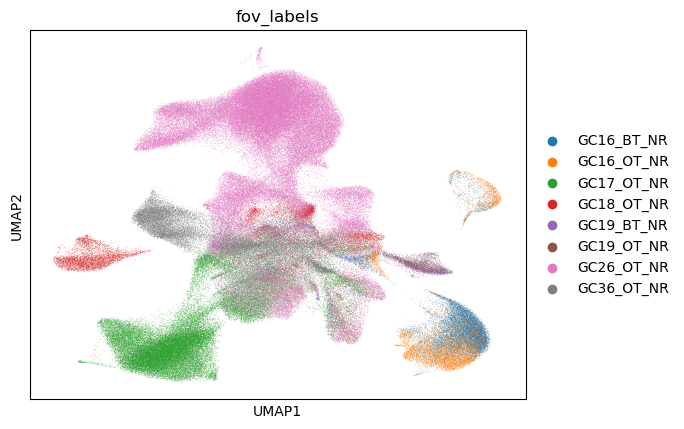

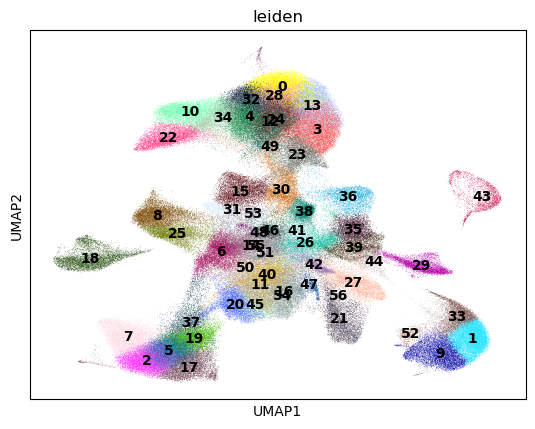

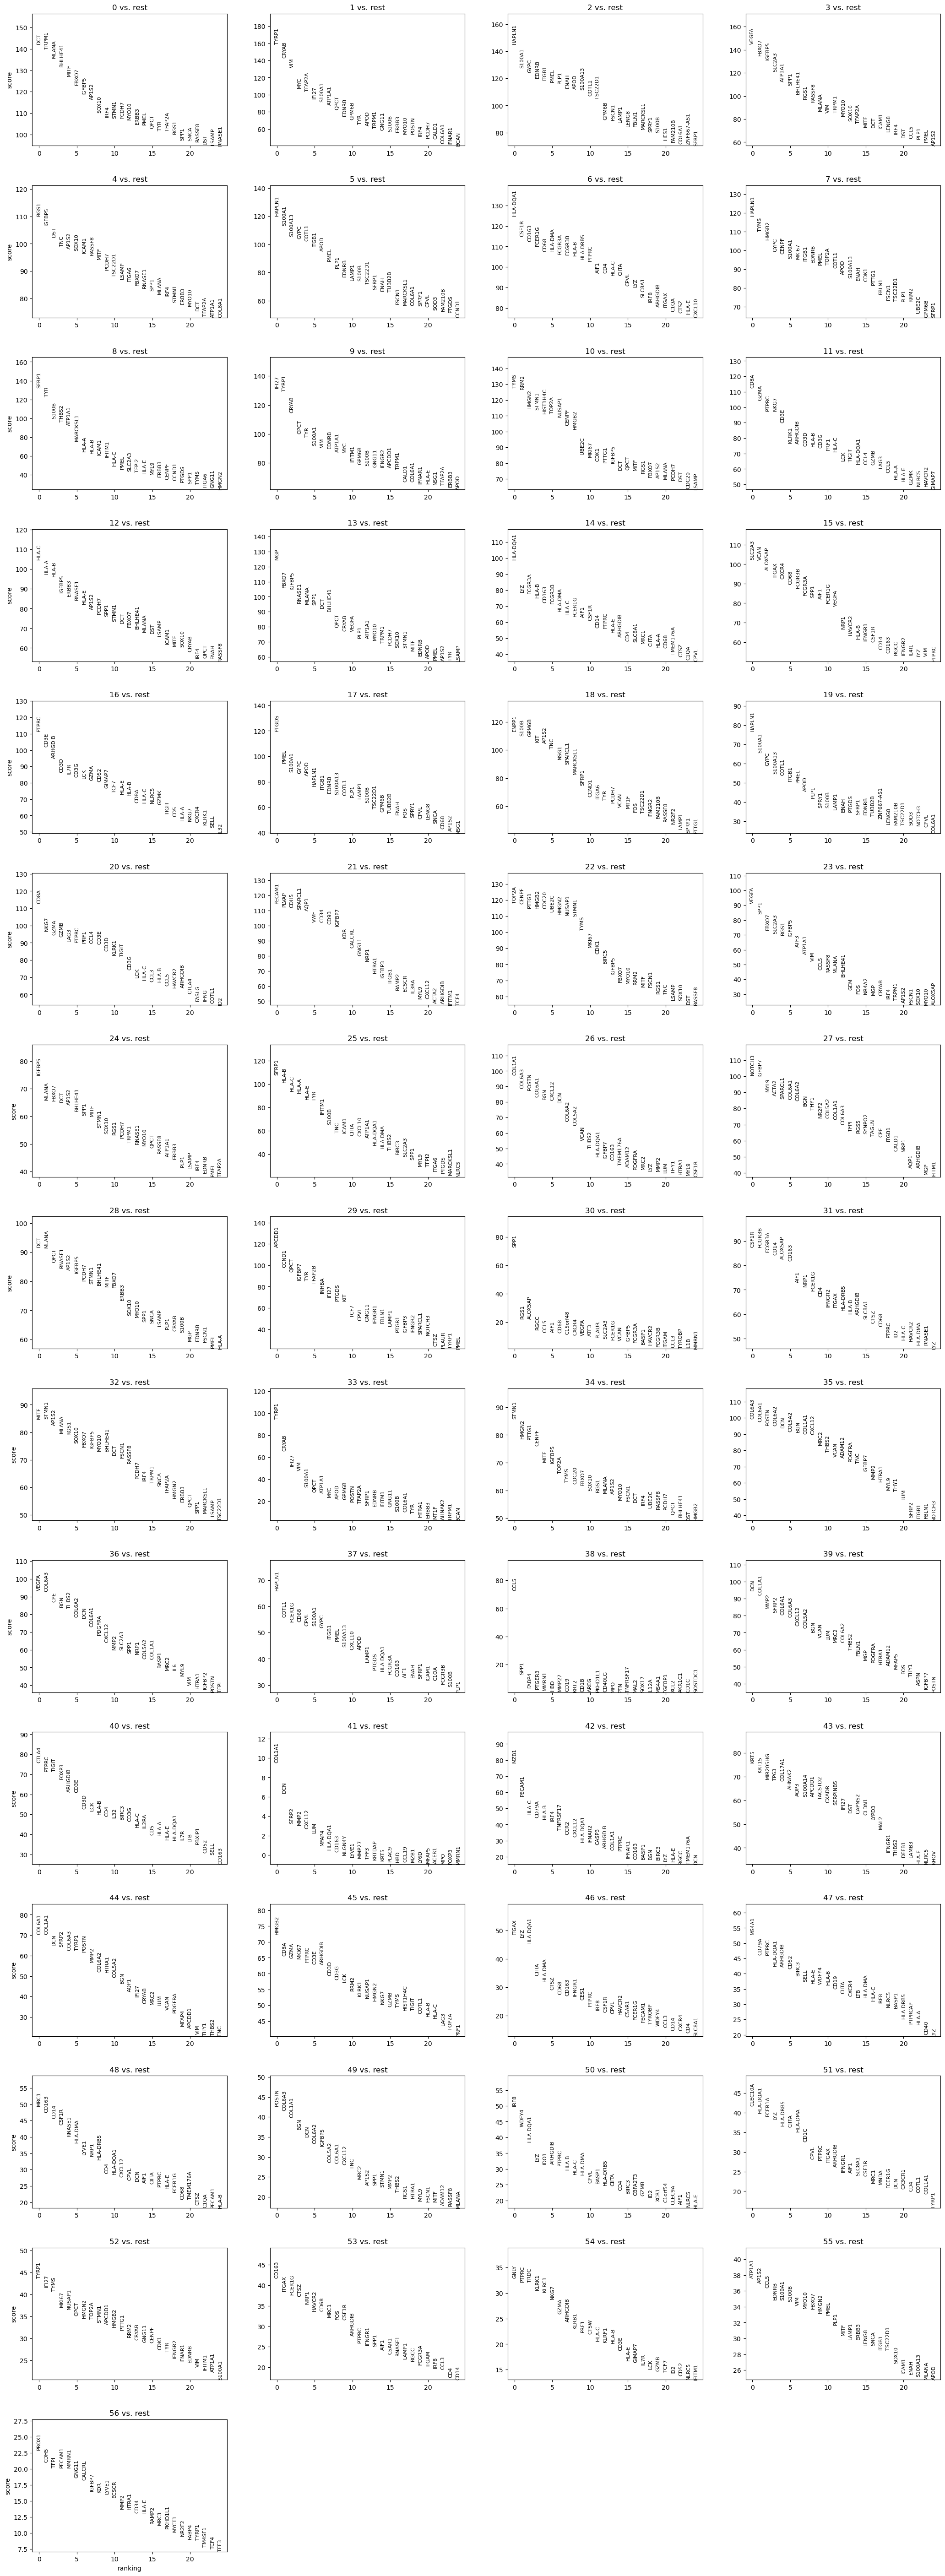

In [20]:
sc.pl.umap(sdata_merged.table, color=["fov_labels"])
sc.pl.umap(sdata_merged.table, color=["leiden"], legend_loc="on data")
sc.pl.rank_genes_groups(sdata_merged.table, n_genes=25, sharey=False)


In [ ]:
import scanpy as sc
gene_list = ['AP1S2', 'ATP1A1', 'EDNRB', 'ERBB3', 'GPM6B', 'MLANA', 'MYO10', 'PLP1', 'S100A1', 'S100B','SOX10', 'TYR', 'TYRP1', 'BGN']
sc.tl.score_genes(sdata_merged.table, gene_list, ctrl_size=50, gene_pool=None, n_bins=10, score_name='MLG_score', random_state=0, copy=False, use_raw=False)
sc.pl.umap(sdata_merged.table, color=['MLG_score'])
#removed FCG receptors
gene_list = ['AREG', 'GNLY', 'KLRB1', 'KLRC1', 'KLRF1', 'KLRK1', 'LAMP1', 'NCAM1', 'TRDC', 'TYROBP', 'XCL1', 'NCR1', 'NKG7', 'XCL2', 'PRF1']
sc.tl.score_genes(sdata_merged.table, gene_list, ctrl_size=50, gene_pool=None, n_bins=10, score_name='NK_cells', random_state=0, copy=False, use_raw=False)
sc.pl.umap(sdata_merged.table, color=['NK_cells'])
sc.pl.violin(sdata_merged.table, keys=['MLG_score'], groupby='leiden', rotation=90)
sc.pl.violin(sdata_merged.table, keys=['NK_cells'], groupby='leiden', rotation=90)
sc.pl.violin(sdata_merged.table, keys=['NK_cells'], groupby='fov_labels', rotation=90)



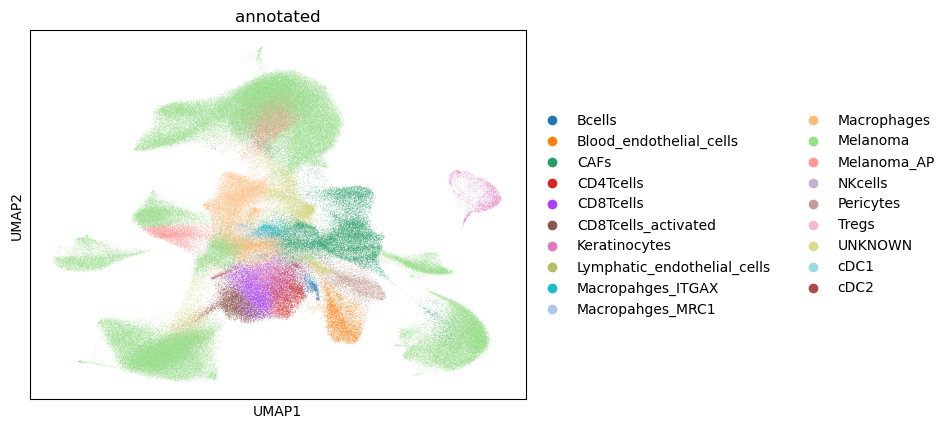

In [ ]:
old_to_new ={'0':'Melanoma',
'1':'Melanoma',
'2':'Melanoma',
'3':'Melanoma',
'4':'Melanoma',
'5':'Melanoma',
'6':'Melanoma',
'7':'Melanoma',
'8':'Melanoma',
'9':'Melanoma',
'10':'Melanoma',
'11':'CD8Tcells',#GZMA
'12':'Melanoma_AP',#HLA
'13':'Melanoma',
'14':'Macrophages',
'15':'Macrophages',#Monocytes?
'16':'CD4Tcells',
'17':'Melanoma',
'18':'Melanoma',
'19':'Melanoma',
'20':'CD8Tcells_activated',
'21':'Blood_endothelial_cells',
'22':'Melanoma',
'23':'Melanoma',
'24':'Melanoma',
'25':'Melanoma_AP',
'26':'CAFs',
'27':'Pericytes',
'28':'Melanoma',
'29':'Melanoma',
'30':'UNKNOWN',
'31':'Macrophages',#Neutro?
'32':'Melanoma',
'33':'Melanoma',
'34':'Melanoma',
'35':'CAFs',
'36':'CAFs',
'37':'UNKNOWN',
'38':'UNKNOWN',
'39':'CAFs',
'40':'Tregs',
'41':'CAFs',
'42':'UNKNOWN',
'43':'Keratinocytes',
'44':'CAFs',
'45':'CD8Tcells',#prolif
'46':'Macropahges_ITGAX',
'47':'Bcells',
'48':'Macropahges_MRC1',
'49':'CAFs',
'50':'cDC1',
'51':'cDC2',
'52':'Melanoma',
'53':'Macrophages',
'54':'NKcells',
'55':'Melanoma',
'56':'Lymphatic_endothelial_cells'}
sdata_merged.table.obs['annotated'] = (
    sdata_merged.table.obs['leiden']
    .map(old_to_new)
    .astype('category')
)
sc.pl.umap(sdata_merged.table, color=['annotated'])
